In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 한글 폰트 설정 (윈도우 기준)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 파일명은 실제 작업 환경에 맞게 수정
승하차_파일 = "../../data/결과/승하차/통합/1호선_승하차인원_통합.csv"
혼잡도_파일 = "../../data/결과/혼잡도/통합/1호선_혼잡도_통합.csv"
시간표_파일 = "../../data/결과/운행시간표/통합/1호선_열차운행시각표.csv"

승하차_df = pd.read_csv(승하차_파일, encoding="euc-kr")
혼잡도_df = pd.read_csv(혼잡도_파일, encoding="euc-kr")
시간표_df = pd.read_csv(시간표_파일, encoding="euc-kr")

In [2]:
# 시간 컬럼 자동 추출
시간칼럼_승하차 = [col for col in 승하차_df.columns if ":" in col]
시간칼럼_혼잡도 = [col for col in 혼잡도_df.columns if ":" in col]

# 승차/하차 분리 롱포맷
승차_long = 승하차_df[승하차_df["구분"] == "승차"].melt(
    id_vars=["연번", "평일주말", "호선", "역번호", "역명", "구분"],
    value_vars=시간칼럼_승하차,
    var_name="시간",
    value_name="승차인원",
)
하차_long = 승하차_df[승하차_df["구분"] == "하차"].melt(
    id_vars=["연번", "평일주말", "호선", "역번호", "역명", "구분"],
    value_vars=시간칼럼_승하차,
    var_name="시간",
    value_name="하차인원",
)

# 승하차 병합
승하차_merge = pd.merge(
    승차_long.drop(columns="구분"),
    하차_long.drop(columns="구분"),
    on=["연번", "평일주말", "호선", "역번호", "역명", "시간"],
    how="outer",
).fillna(0)
승하차_merge["승차인원"] = 승하차_merge["승차인원"].astype(int)
승하차_merge["하차인원"] = 승하차_merge["하차인원"].astype(int)

# 혼잡도 롱포맷
혼잡도_long = 혼잡도_df.melt(
    id_vars=["연번", "평일주말", "호선", "역번호", "역명", "구분"],
    value_vars=시간칼럼_혼잡도,
    var_name="시간",
    value_name="혼잡도",
)

# 시간 문자열 5자리로 맞추기
for df_temp in [승하차_merge, 혼잡도_long]:
    df_temp["시간"] = df_temp["시간"].astype(str).str.zfill(5)

In [4]:
def convert_time_with_over24(time_str):
    if pd.isna(time_str):
        return pd.NaT
    try:
        hh, mm, ss = time_str.split(":")
        hh, mm, ss = int(hh), int(mm), int(ss)
    except:
        return pd.NaT
    if hh >= 24:
        hh = hh - 24
        return pd.to_datetime(f"2000-01-02 {hh:02d}:{mm:02d}:{ss:02d}")
    else:
        return pd.to_datetime(f"2000-01-01 {hh:02d}:{mm:02d}:{ss:02d}")


시간표_df["열차도착시간_dt"] = 시간표_df["열차도착시간"].apply(convert_time_with_over24)
시간표_df = 시간표_df.sort_values(["호선", "열차코드", "열차도착시간_dt"])

In [5]:
def get_closest_info(df, 시각, 평일주말, 역명, 호선, cols):
    subset = df[
        (df["호선"] == 호선) & (df["역명"] == 역명) & (df["평일주말"] == 평일주말)
    ].copy()
    if "시간_dt" not in subset.columns:
        subset["시간_dt"] = pd.to_datetime(
            subset["시간"], format="%H:%M", errors="coerce"
        )
    subset = subset[subset["시간_dt"].notna()]
    subset = subset[subset["시간_dt"] <= 시각]
    if subset.empty:
        return [0] * len(cols)
    closest = subset.iloc[-1]
    return [closest[c] for c in cols]

In [6]:
예시_호선 = 1
예시_열차코드 = "K101"

열차경로 = []
누적_인원 = 0
df_특정열차 = 시간표_df[
    (시간표_df["호선"] == 예시_호선) & (시간표_df["열차코드"] == 예시_열차코드)
]

for _, row in df_특정열차.iterrows():
    역명 = row["역명"]
    은_평일주말 = row["평일주말"]
    도착시 = row["열차도착시간_dt"]
    호선 = row["호선"]

    승차, 하차 = get_closest_info(
        승하차_merge, 도착시, 은_평일주말, 역명, 호선, ["승차인원", "하차인원"]
    )
    혼잡도 = get_closest_info(혼잡도_long, 도착시, 은_평일주말, 역명, 호선, ["혼잡도"])[
        0
    ]

    누적_인원 = max(0, 누적_인원 + int(승차) - int(하차))

    열차경로.append(
        {
            "역명": 역명,
            "도착시간": 도착시,
            "평일주말": 은_평일주말,
            "승차인원": 승차,
            "하차인원": 하차,
            "혼잡도": 혼잡도,
            "누적열차내인원": 누적_인원,
        }
    )

열차경로_df = pd.DataFrame(열차경로).dropna(subset=["혼잡도"])

In [7]:
def create_sequences(df, time_steps=3):
    features = df[["승차인원", "하차인원", "혼잡도"]].values
    target = df["누적열차내인원"].values
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i : i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)


TIME_STEPS = 3
X, y = create_sequences(열차경로_df, TIME_STEPS)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_reshape = X.reshape(-1, X.shape[2])
X_scaled = scaler_X.fit_transform(X_reshape).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [8]:
model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=(TIME_STEPS, X.shape[2])))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.fit(X_scaled, y_scaled, epochs=50, batch_size=8)

y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

Epoch 1/50


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7295e-06   
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5085e-06 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3179e-06 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1373e-06 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4856e-06 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3748e-06 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9427e-06 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0497e-06 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3939e-07 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1535e-07 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3084e-07 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2191e-07 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0286e-08 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3349e-08 
Epoch 15/50
12/12 ━━━━━━

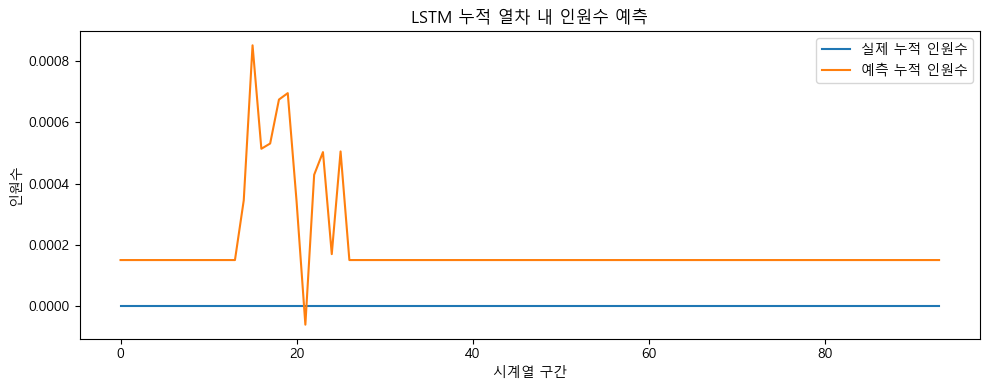

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(y, label="실제 누적 인원수")
plt.plot(y_pred.flatten(), label="예측 누적 인원수")
plt.legend()
plt.title("LSTM 누적 열차 내 인원수 예측")
plt.xlabel("시계열 구간")
plt.ylabel("인원수")
plt.tight_layout()
plt.show()

# 결과 CSV 저장 (euc-kr)
pd.DataFrame(
    {"실제 누적 인원수": y.flatten(), "예측 누적 인원수": y_pred.flatten()}
).to_csv("lstm_예측결과.csv", encoding="euc-kr", index=False)